In [1]:
import cftime
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from scipy import stats

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [22]:
mission_list = glob.glob('../microSWIFT_data/final_dataset/mission_*.nc')
bathy_file = '../microSWIFT_data/FRFdata/' \
             'FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc'
array_8m_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_8m-array_202110.nc'
awac_6m_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-6m_202110.nc'

print(len(mission_list))

67


In [23]:
microSWIFT_sig_wave_heights_os = []
mission_times_os = []
awac_sig_wave_heights_os = []
num_waves_in_mission_os = []
standard_deviations_os = []
wave_heights_each_mission_os = []
array_8m_sig_wave_heights_os = []
awac_6m_sig_wave_heights_os = []
array_8m_Tm_os = []
awac_6m_Tm_os = []
average_x_loc_os = []
average_y_loc_os = []
array_8m_dir_os = []
total_drift_tracks = 0 

# Cross Shore Location for start of Breaking
bathy_dataset = nc.Dataset(bathy_file)

# Create grid from coordinates
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]

# Based on Raubenheimer 1996 the average gamma value at Duck is approximately .35
gamma = 0.35

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    x_locations = mission_dataset['xFRF'][:]
    y_locations = mission_dataset['yFRF'][:]
    eta = mission_dataset['sea_surface_elevation'][:]
    time = mission_dataset['time'][:]

    # Update total drift tracks
    total_drift_tracks += x_locations.shape[0]

    wave_heights, \
    wave_x_locs, \
    wave_y_locs = mission_tools.compute_individual_waves(x_locations,
                                                        y_locations,
                                                        eta, time,
                                                        bathy_file)
    
    wave_bathy = mission_tools.compute_wave_bathy(wave_x_locs,
                                                  wave_y_locs,
                                                  bathy_file)
    wave_heights_os = []
    wave_periods_os = []
    wave_x_loc_os = []
    wave_y_loc_os = []

    # Compute approximate cross shore location of surf zone 
    mission_hs = mission_tools.closest_awac_sig_wave_height(np.median(time), array_8m_file)

    # Compute depth that waves should be breaking in 
    mission_break_depth = mission_hs / gamma

    for n in np.arange(len(wave_bathy)):
        if wave_bathy[n] > -mission_break_depth:
            wave_heights_os.append(wave_heights[n])
            wave_x_loc_os.append(wave_x_locs[n])
            wave_y_loc_os.append(wave_y_locs[n])

    if len(wave_heights_os) > 30:
        wave_heights_each_mission_os.append(wave_heights_os)
        significant_wave_height_os, \
        standard_dev_os = mission_tools.compute_sig_wave_height_top_third(wave_heights_os)
        microSWIFT_sig_wave_heights_os.append(significant_wave_height_os)
        standard_deviations_os.append(standard_dev_os)
        average_x_loc_os.append(np.mean(wave_x_loc_os))
        average_y_loc_os.append(np.mean(wave_y_loc_os))

        mission_time = np.median(mission_dataset['time'][:])
        mission_times_os.append(mission_time)
        num_waves_in_mission_os.append(len(wave_heights_os))
        awac_sig_wave_heights_os.append(mission_tools.closest_awac_sig_wave_height(mission_time, awac_file))
        array_8m_sig_wave_heights_os.append(mission_tools.closest_awac_sig_wave_height(mission_time, array_8m_file))
        awac_6m_sig_wave_heights_os.append(mission_tools.closest_awac_sig_wave_height(mission_time, awac_6m_file))
        array_8m_Tm_os.append(mission_tools.closest_awac_Tm(mission_time, array_8m_file))
        awac_6m_Tm_os.append(mission_tools.closest_awac_Tm(mission_time, awac_6m_file))
        array_8m_dir_os.append(mission_tools.closest_awac_dir(mission_time, array_8m_file))
    else:
        continue

/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [24]:
print(f'The total number of drfit tracks in the dataset is {total_drift_tracks}')

The total number of drfit tracks in the dataset is 971


In [5]:
mission_times_date_os = cftime.num2pydate(mission_times_os,
                                          units=mission_dataset['time'].units,
                                          calendar=mission_dataset['time'].calendar)

# Compute the RMS wave height from the first sete of wave heights
ci_for_mission = []
rms_wave_height_for_mission = []

for n in range(len(mission_times_date_os)):
    wave_heights = np.array(wave_heights_each_mission_os[n])
    rms_wave_height = mission_tools.compute_rms_wave_height(wave_heights)
    rms_wave_height_for_mission.append(rms_wave_height)

    # Compute the 95% confidence interval for the RMS wave height using a bootstrap
    wave_heights = (wave_heights,) # data must be in a sequence for the bootstrap function
    bootstrap_ci = stats.bootstrap(wave_heights, mission_tools.compute_rms_wave_height, confidence_level=0.95, method='percentile')
    ci_low = bootstrap_ci.confidence_interval[0]
    ci_high = bootstrap_ci.confidence_interval[1]
    ci_for_mission.append(ci_high - ci_low)

# Convert to numpy arrays
rms_wave_height_for_mission = np.array(rms_wave_height_for_mission)
hs_wave_height_for_mission = rms_wave_height_for_mission * 1.4
ci_for_mission = np.array(ci_for_mission)

In [11]:
# Along Shore Distance to Pier for the wave heights
# Pier is at a y location of 505 meters
alongshore_dist_to_pier = np.array([ (505 - y_loc) for y_loc in average_y_loc_os])

In [9]:
# Correct the 6 and 8 meter sensors to the the 4.5 m depth 
omega_8marray = 2 * np.pi / np.array(array_8m_Tm_os)
omega_6mawac = 2 * np.pi / np.array(awac_6m_Tm_os)
wavenumber_8marray = np.empty(omega_8marray.size)
wavenumber_8marray_os = np.empty(omega_8marray.size)
wavenumber_6mawac = np.empty(omega_6mawac.size)
wavenumber_6mawac_os = np.empty(omega_6mawac.size)

for n in range(wavenumber_8marray.size):
    wavenumber_8marray[n] = mission_tools.solve_dispersion_relation(g=9.8, 
                                                                    h=8,
                                                                    omega=omega_8marray[n])
    wavenumber_8marray_os[n] = mission_tools.solve_dispersion_relation(g=9.8, 
                                                                       h=4.8,
                                                                       omega=omega_8marray[n])
    wavenumber_6mawac[n] = mission_tools.solve_dispersion_relation(g=9.8, 
                                                                   h=6,
                                                                   omega=omega_6mawac[n])
    wavenumber_6mawac_os[n] = mission_tools.solve_dispersion_relation(g=9.8, 
                                                                      h=4.8,
                                                                      omega=omega_6mawac[n])

# Compute the group speed of at each station and at 4.8 meters
cg_8marray = mission_tools.compute_group_speed(wavenumber_8marray, 8)
cg_8marray_os = mission_tools.compute_group_speed(wavenumber_8marray_os, 4.8)
shoaling_coeff_8marray = np.sqrt(cg_8marray/cg_8marray_os)
array_8m_sig_wave_heights_os_shoaled = array_8m_sig_wave_heights_os * shoaling_coeff_8marray

cg_6mawac = mission_tools.compute_group_speed(wavenumber_6mawac, 6)
cg_6mawac_os = mission_tools.compute_group_speed(wavenumber_6mawac_os, 4.8)
shoaling_coeff_6mawac = np.sqrt(cg_6mawac/cg_6mawac_os)
awac_6m_sig_wave_heights_os_shoaled = awac_6m_sig_wave_heights_os * shoaling_coeff_6mawac

In [10]:
# Compute the root-mean-square-error between the microSWIFT arrays and the 4.5 m AWAC
def rmse(estimate, actual):
    return np.sqrt(np.mean(np.square(estimate - actual)))

rmse_microswifts = rmse(hs_wave_height_for_mission, awac_sig_wave_heights_os)
print(f'The RMSE for the microSWIFT significant wave heights is {np.round(rmse_microswifts, 3)} meters.')

# Adjust RMSE for the shoaling corrected Hs
rmse_8marray_shoaled = rmse(np.array(array_8m_sig_wave_heights_os_shoaled), awac_sig_wave_heights_os)
print(f'The RMSE for the 8m Array significant wave heights is {np.round(rmse_8marray_shoaled, 3)} meters.')

rmse_6mawac_shoaled = rmse(np.array(awac_6m_sig_wave_heights_os_shoaled), awac_sig_wave_heights_os)
print(f'The RMSE for the 6m AWAC significant wave heights is {np.round(rmse_6mawac_shoaled, 3)} meters.')

The RMSE for the microSWIFT significant wave heights is 0.375 meters.
The RMSE for the 8m Array significant wave heights is 0.068 meters.
The RMSE for the 6m AWAC significant wave heights is 0.064 meters.


3.5008827024121546e-18


(0.0, 4.5)

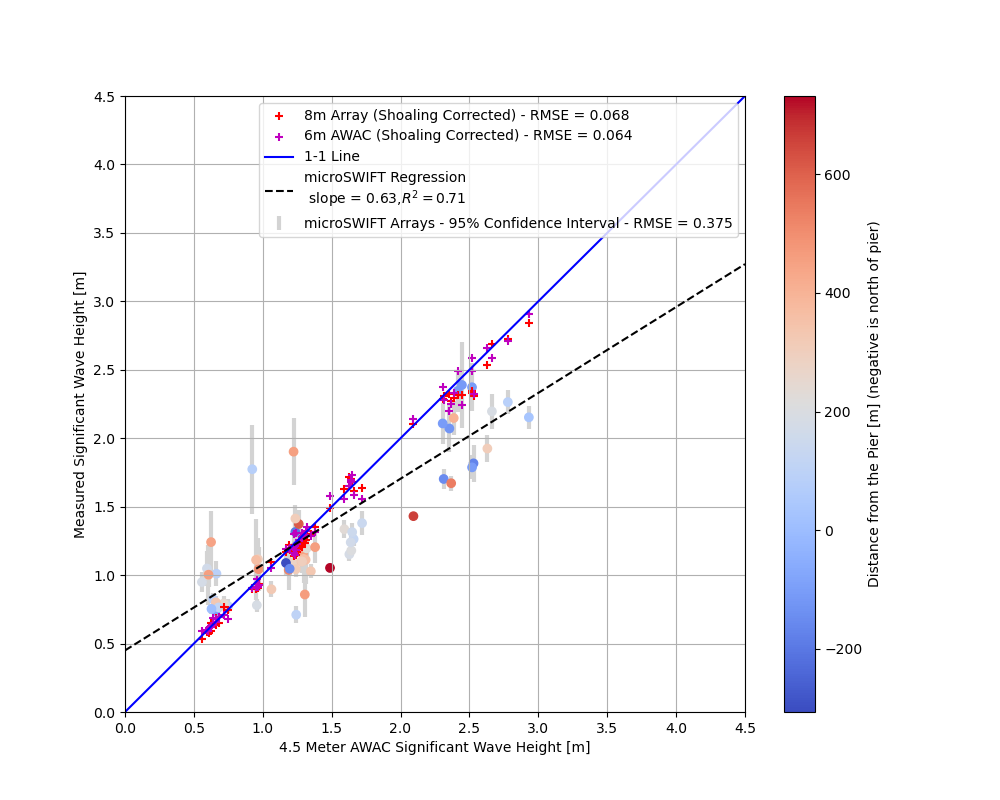

In [16]:
# Compute linear regression between the microSWIFT arrays and the AWAC
slope_os, \
intercept_os, \
r_value_os, \
p_value_os, \
std_err_os = stats.linregress(awac_sig_wave_heights_os, 
                              microSWIFT_sig_wave_heights_os)
print(p_value_os)
x_os = np.linspace(0, 4.5)
y_os = slope_os * x_os + intercept_os

fig, ax = plt.subplots(figsize=(10,8))
ax.errorbar(awac_sig_wave_heights_os, hs_wave_height_for_mission, yerr=ci_for_mission, fmt='none', marker=None,
            ecolor='lightgray', elinewidth=3, capsize=0,
            label=f'microSWIFT Arrays - 95% Confidence Interval - RMSE = {np.round(rmse_microswifts, 3)}',
            zorder=0)
im = ax.scatter(awac_sig_wave_heights_os, hs_wave_height_for_mission, c=alongshore_dist_to_pier, cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Distance from the Pier [m] (negative is north of pier)')
ax.scatter(awac_sig_wave_heights_os, array_8m_sig_wave_heights_os_shoaled, color='r', marker='+', label=f'8m Array (Shoaling Corrected) - RMSE = {np.round(rmse_8marray_shoaled, 3)}')
ax.scatter(awac_sig_wave_heights_os, awac_6m_sig_wave_heights_os_shoaled, color='m', marker='+', label=f'6m AWAC (Shoaling Corrected) - RMSE = {np.round(rmse_6mawac_shoaled, 3)}')
ax.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax.plot(x_os, y_os, color='k', linestyle='dashed', 
        label='microSWIFT Regression \n slope = {0:.2f},' \
              '$R^2 = {1:.2f}$'.format(slope_os, r_value_os**2))
ax.set_ylabel('Measured Significant Wave Height [m]')
ax.set_xlabel('4.5 Meter AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)

In [29]:
# Adjust wave direction to be relative to shore normal 
array_8m_dir_os_shore_norm = np.array(array_8m_dir_os) - 71.8
print(array_8m_dir_os_shore_norm)
print(array_8m_dir_os_shore_norm.size)
# NOTE: negative is from the north and positive is from the south

# Determine if the microSWIFT missions are in the shadow of the pier
in_pier_shadow = []
for n in range(alongshore_dist_to_pier.size):
    if np.abs(alongshore_dist_to_pier[n]) < 200:
        if np.abs(array_8m_dir_os_shore_norm[n]) > 5:
            in_pier_shadow.append(np.sign(alongshore_dist_to_pier[n] * array_8m_dir_os_shore_norm[n]))
        else:
            in_pier_shadow.append(1)
    else:
        in_pier_shadow.append(1)

in_pier_shadow = np.array(in_pier_shadow, dtype=int)
print(in_pier_shadow)
print(in_pier_shadow.size)

[  8.92818326 -13.20147821  -8.79234547   8.88059124 -13.10508667
 -39.15050625  -4.11013573  13.52183649  -4.86317578   3.7678363
   9.21275501 -14.83113032  -9.58707724   3.18048619 -11.32069799
  12.57631332  10.32636836 -11.79474545  -3.89762065  -4.0133223
 -41.75049476  28.60866471 -33.81067711  -9.04479805   8.67784012
 -12.93608324   2.17101881 -32.21948404  -9.31509702 -13.61819304
   8.81817076 -13.44060794   1.98343516  16.00027513   9.70042323
 -11.50587841  -2.06556061  -4.47831547 -12.62430483 -36.96854381
  -8.34668439   9.30078033   7.26935437 -14.76359349  13.0395805
   1.44376771 -33.86016677  -2.5412533  -40.20262918  -5.17543295
  30.65178526 -13.91889402   0.78682307 -11.67679127 -33.06740837
  -6.39477825 -13.05993449  -8.08549375 -34.87810404   8.56730494
 -15.29848952  12.9897973    1.30715182]
63
[-1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1 -1  1 -1  1  1  1  1 -1  1  1
 -1 -1  1 -1  1  1 -1  1  1  1 -1 -1  1  1  1  1  1  1 -1  1  1  1  1  1
 -1  1  1  1  1 -1 -1

(0.0, 4.5)

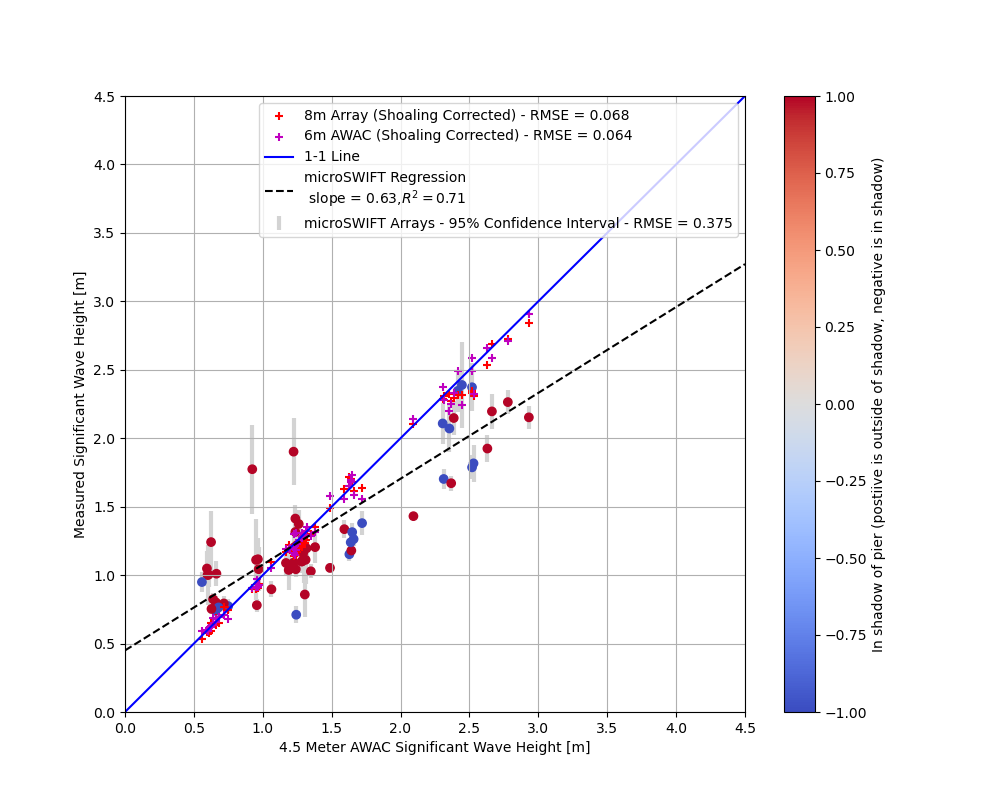

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
ax.errorbar(awac_sig_wave_heights_os, hs_wave_height_for_mission, yerr=ci_for_mission, fmt='none', marker=None,
            ecolor='lightgray', elinewidth=3, capsize=0,
            label=f'microSWIFT Arrays - 95% Confidence Interval - RMSE = {np.round(rmse_microswifts, 3)}',
            zorder=0)
im = ax.scatter(awac_sig_wave_heights_os, hs_wave_height_for_mission, c=in_pier_shadow, cmap='coolwarm',
                vmin=-1, vmax=1)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('In shadow of pier (postiive is outside of shadow, negative is in shadow)')
ax.scatter(awac_sig_wave_heights_os, array_8m_sig_wave_heights_os_shoaled, color='r', marker='+', label=f'8m Array (Shoaling Corrected) - RMSE = {np.round(rmse_8marray_shoaled, 3)}')
ax.scatter(awac_sig_wave_heights_os, awac_6m_sig_wave_heights_os_shoaled, color='m', marker='+', label=f'6m AWAC (Shoaling Corrected) - RMSE = {np.round(rmse_6mawac_shoaled, 3)}')
ax.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax.plot(x_os, y_os, color='k', linestyle='dashed', 
        label='microSWIFT Regression \n slope = {0:.2f},' \
              '$R^2 = {1:.2f}$'.format(slope_os, r_value_os**2))
ax.set_ylabel('Measured Significant Wave Height [m]')
ax.set_xlabel('4.5 Meter AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)